In [42]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import json

In [43]:
parent_dir = '/Volumes/language/language/NeuroImaging_Scripts/voxel_stats_data'
original_timeseries = pd.read_csv(os.path.join(parent_dir, 'controls/TimeSeries/13281_2016-10-14_rois_timeseries.csv'), header=None)

In [44]:
# def create_mapped_timeseries(original_timeseries, network_name, network_dictionary, subregions):
#     #Import network dictionary
#     with open(network_dictionary) as file:
#         Yeo_7network_names = json.load(file)
#     networks = pd.read_csv(subregions)
#     network_mapping = networks.set_index('Label')[f'{network_name}'].to_dict()
#     mapped_timeseries = original_timeseries.iloc[:, 0].map(network_mapping)
#     new_timeseries = original_timeseries.iloc[:, 4:]
#     new_timeseries[f'{network_name}'] = mapped_timeseries
#     yeo_networks = new_timeseries['Yeo_7network'].unique()
#     return new_timeseries, yeo_networks, Yeo_7network_names

In [50]:
# Function to load the network names from a JSON file
def load_network_names(json_filepath):
    with open(json_filepath, 'r') as file:
        data = json.load(file)
        # Convert keys from strings to integers
        return {int(k): v for k, v in data.items()}

### Intra-Network and Inter-Network Connectivity

In [52]:
#Intra-Network Connectivity
def calculate_intra_network_connectivity(original_timeseries, new_timeseries, network_json_path):
    network_names = load_network_names(network_json_path)
    intra_network_connectivity = {}
    ordered_networks = network_names.keys()
    for network in ordered_networks:
        if network != 0:
            network_data = original_timeseries[new_timeseries['Yeo_7network'] == network]
            correlation_matrix = network_data.transpose().corr()
            average_corr = np.mean(correlation_matrix.values[np.triu_indices_from(correlation_matrix, k=1)])
            intra_network_connectivity[network] = average_corr
    return intra_network_connectivity

#Inter-Network Connectivity
def calculate_inter_network_connectivity(original_timeseries, new_timeseries, network_json_path):
    inter_network_connectivity = {}
    network_names = load_network_names(network_json_path)
    ordered_networks = network_names.keys()
    for i, network_i in enumerate(ordered_networks):
        for j, network_j in enumerate(ordered_networks):
            if network_i != network_j and network_i != 0 and network_j != 0:
                data_i = original_timeseries[new_timeseries['Yeo_7network'] == network_i]
                data_j = original_timeseries[new_timeseries['Yeo_7network'] == network_j]
                correlation_values = []
                for index_i, row_i in data_i.iterrows():
                    for index_j, row_j in data_j.iterrows():
                        correlation_values.append(row_i.corr(row_j))
                average_corr = np.mean(correlation_values)
                key = (network_i, network_j)
                inter_network_connectivity[key] = average_corr
    return inter_network_connectivity

In [67]:
def plot_inter_intra_network_connectivity(intra_network_connectivity, inter_network_connectivity, ordered_networks, network_json_path):
    matrix_df = pd.DataFrame(np.zeros((len(ordered_networks), len(ordered_networks))), index=ordered_networks, columns=ordered_networks)
    for key, value in inter_network_connectivity.items():
        network_i, network_j = key
        matrix_df.loc[network_i, network_j] = value
        matrix_df.loc[network_j, network_i] = value
    if 0 in matrix_df.index:
        matrix_df.drop(0, axis=0, inplace=True)
        matrix_df.drop(0, axis=1, inplace=True)
    mask = np.triu(np.ones_like(matrix_df, dtype=bool))
    
    Yeo_7network_names = load_network_names(network_json_path)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [0.4, 1]})

    
    network_labels = [Yeo_7network_names.get(network, f'Network {network}') for network in matrix_df.index]
    intra_network_values = [intra_network_connectivity[network] for network in matrix_df.index]

    ax1.barh(network_labels, intra_network_values, color='blue')
    ax1.set_title('Intra-Network Connectivity')
    ax1.set_xlim(0, max(intra_network_connectivity.values()) + 0.1)
    ax1.set_xlabel('Average Correlation')
    ax1.grid(axis='x')
    sns.heatmap(matrix_df, cmap="coolwarm", annot=True, linewidths=.5, mask=mask, ax=ax2, cbar_kws={"shrink": 0.8})
    ax2.set_xticks(np.arange(0.5, len(matrix_df.index)))
    ax2.set_xticklabels(network_labels, rotation=45)
    ax2.set_yticks(np.arange(0.5, len(matrix_df.index)))
    ax2.set_yticklabels(network_labels, rotation=0)
    ax2.set_title("Inter-Network Connectivity")
    plt.tight_layout()
    plt.show()

In [70]:
def calculate_and_plot_inter_intra_network_connectivity(timeseries_csv, subregions_csv, network_json_path):
    original_timeseries = pd.read_csv(timeseries_csv)
    original_timeseries = original_timeseries.drop(original_timeseries.columns[233], axis=1)

    networks = pd.read_csv(subregions_csv)
    network_names = load_network_names(network_json_path)
    ordered_networks = network_names.keys()
    network_mapping = networks.set_index('Label')['Yeo_7network'].to_dict()
    mapped_timeseries = original_timeseries.iloc[:, 0].map(network_mapping)
    new_timeseries = original_timeseries.iloc[:, 4:]
    new_timeseries['Yeo_7network'] = mapped_timeseries
    original_timeseries = original_timeseries.iloc[:, 4:]

    # Intra-Network Connectivity
    intra_network_connectivity = calculate_intra_network_connectivity(original_timeseries, new_timeseries, network_json_path)
    # Inter-Network Connectivity
    inter_network_connectivity = calculate_inter_network_connectivity(original_timeseries, new_timeseries, network_json_path)
    # Plot
    plot_inter_intra_network_connectivity(intra_network_connectivity, inter_network_connectivity, ordered_networks, network_json_path)


dict_keys([1, 2, 3, 4, 5, 6, 7])


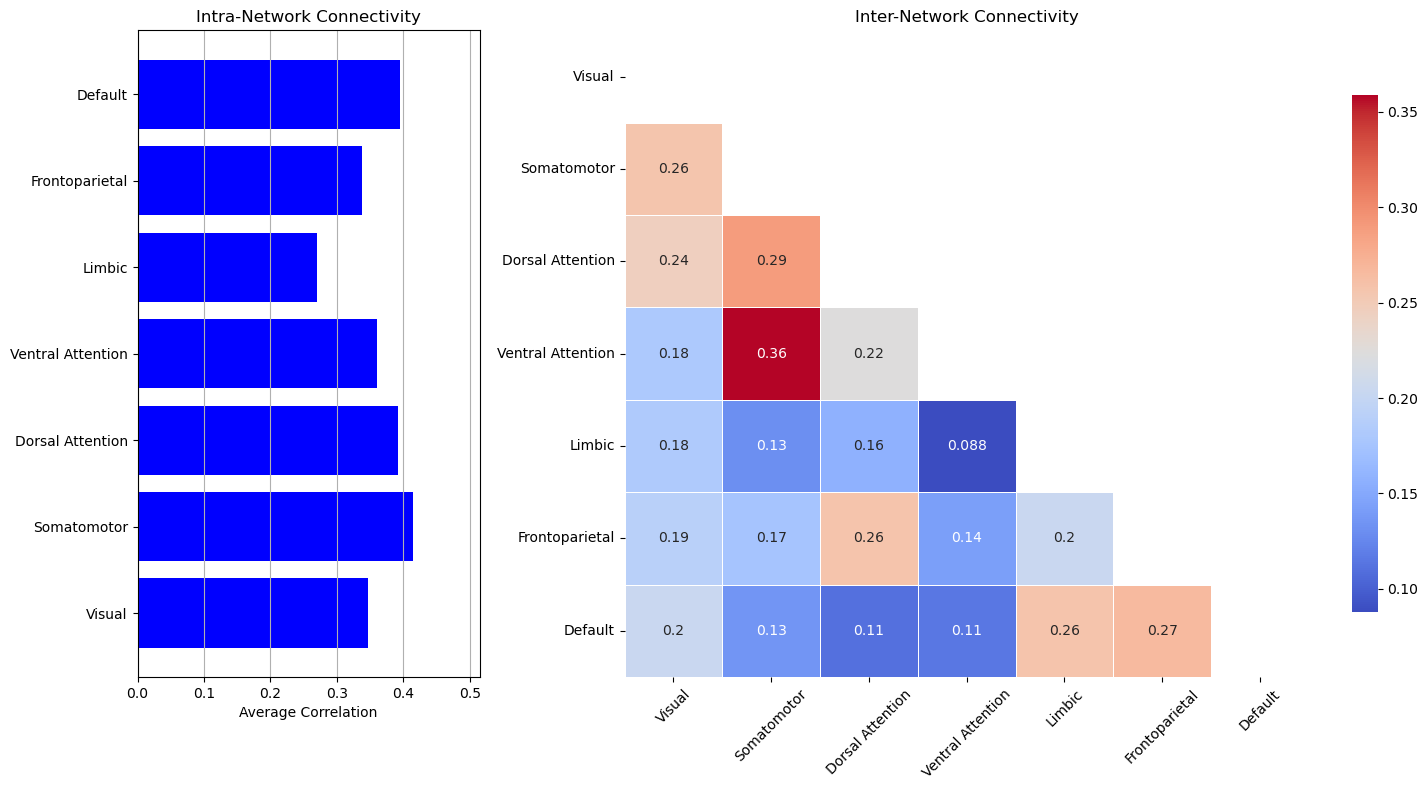

In [71]:
parent_dir = '/Volumes/language/language/NeuroImaging_Scripts/voxel_stats_data'
timeseries_csv = (os.path.join(parent_dir, 'controls/TimeSeries/13281_2016-10-14_rois_timeseries.csv'))
network_json_path = './Yeo_7network_names.json'
subregions_csv = './subregion_func_network_Yeo_updated.csv'

calculate_and_plot_inter_intra_network_connectivity(timeseries_csv, subregions_csv, network_json_path)